In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt

import AISMapPlot as aismap

In [2]:
# Load the data
names = ['TripID', 'MMSI', 'StartLatitude', 'StartLongitude', 'StartTime', 'EndLatitude', 'EndLongitude', 'EndTime',
         'StartPort', 'EndPort', 'ID', 'time', 'shiptype', 'Length', 'Breadth', 'Draught', 'Latitude', 'Longitude',
         'SOG', 'COG', 'TH', 'Destination', 'Name', 'Callsign', 'AisSourcen']
ais = pd.read_csv('rotterdam_hamburg.arff', names = names, skiprows = 27, parse_dates = True,
                  na_values = ['?'], dtype = {'TripID': str, 'MMSI': str, 'shiptype': str})

In [3]:
ais.head()

,TripID,MMSI,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,StartPort,EndPort,...,Draught,Latitude,Longitude,SOG,COG,TH,Destination,Name,Callsign,AisSourcen
0,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.82,14.7,81.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a
1,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.83,14.7,80.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a
2,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.83,14.7,81.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a
3,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.84,14.7,80.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a
4,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.85,14.7,81.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a


In [4]:
ais_nan = ais

In [5]:
# Convert time columns to correct dtype
ais_nan['StartTime'] = pd.to_datetime(ais_nan['StartTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['EndTime'] = pd.to_datetime(ais_nan['EndTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['time'] = pd.to_datetime(ais_nan['time'], format = '\'%Y-%m-%d %H:%M\'')

In [6]:
# Convert all headings that are 511 (>= 360) to NaN
ais_nan.loc[ais_nan['TH'] >= 360, 'TH'] = np.nan

In [7]:
# Convert courses >= 360 to NaN
ais_nan.loc[ais_nan['COG'] >= 360, 'COG'] = np.nan

In [8]:
# Set invalid shiptypes to NaN
# Invalid shiptypes existing in the data set are '0' and '159'
ais_nan.loc[(ais_nan['shiptype'] == '0') | (ais_nan['shiptype'] == '159'), 'shiptype'] = np.nan

In [9]:
# Set invalid lengths (0 or > 400) to NaN
ais_nan.loc[(ais_nan['Length'] <= 0) | (ais_nan['Length'] > 400), 'Length'] = np.nan

In [10]:
# Set invalid lengths (0 or > 59) to NaN
ais_nan.loc[(ais_nan['Breadth'] <= 0) | (ais_nan['Breadth'] > 59), 'Breadth'] = np.nan

In [11]:
# Set speeds that are unrealisticly high to NaN
ais_nan.loc[ais_nan['SOG'] > 25.6, 'SOG'] = np.nan

In [12]:
ais_dropped = ais_nan.drop(['AisSourcen', 'ID', 'StartPort', 'EndPort', 'Name', 'MMSI', 'shiptype'], axis = 1)

In [13]:
ais_dropped.loc[(ais_dropped['TH'] <= 0.0) & (ais_dropped['TH'] >= 0.0)].describe()

,StartLatitude,StartLongitude,EndLatitude,EndLongitude,Length,Breadth,Draught,Latitude,Longitude,SOG,COG,TH
count,3005.000000,3005.000000,3005.000000,3005.000000,2994.000000,2994.000000,2834.000000,3005.000000,3005.000000,3005.000000,3003.000000,3005.0
mean,51.934047,4.124163,53.520080,9.924063,264.914162,36.546092,10.173038,52.506988,4.478755,11.126156,183.146687,0.0
std,0.043017,0.159264,0.019295,0.055290,86.754507,11.561947,2.529968,1.031506,1.568901,4.794966,172.036605,0.0
min,51.680000,3.900000,53.420000,9.510000,70.000000,9.000000,0.300000,51.280000,0.320000,0.200000,0.000000,0.0
25%,51.940000,4.040000,53.500000,9.910000,199.000000,30.000000,9.200000,52.060000,3.880000,8.100000,3.000000,0.0
50%,51.950000,4.060000,53.530000,9.930000,275.000000,32.000000,10.280000,52.130000,3.900000,11.600000,247.900000,0.0
75%,51.950000,4.110000,53.530000,9.950000,337.000000,48.000000,12.000000,52.350000,3.920000,14.500000,357.000000,0.0
max,52.070000,4.720000,53.660000,10.370000,400.000000,59.000000,14.210000,59.260000,11.040000,22.800000,359.900000,0.0


Text(0.5,1,u'All Positions Before Filtering')

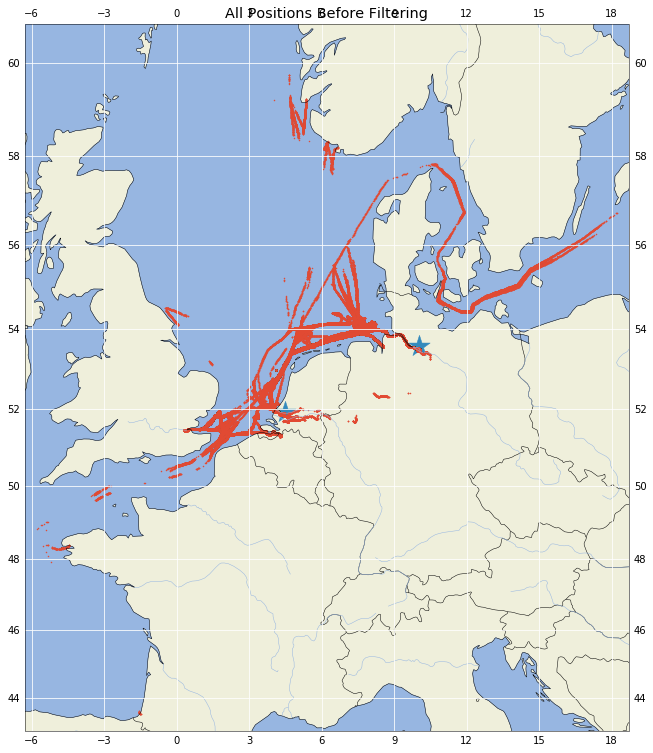

In [14]:
# Plot all positions in the data before any filters are applied
aismap.plot_to_map(size = (13, 13), longitude = ais_dropped['Longitude'], latitude = ais_dropped['Latitude'])
plt.title("All Positions Before Filtering")

Text(0.5,1,u'Start Positions Before Filtering')

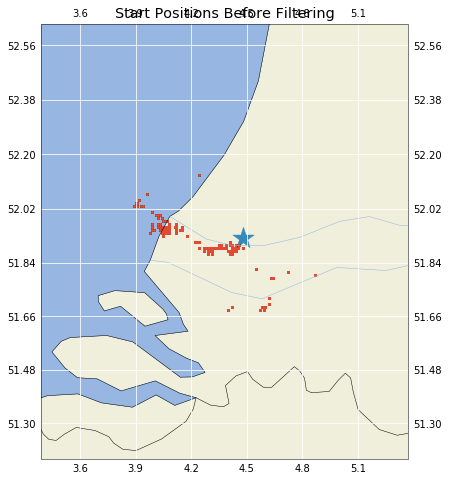

In [15]:
# Plot start positions before any filtering to map
aismap.plot_to_map(size = (8, 8), longitude = ais_dropped['StartLongitude'], latitude = ais_dropped['StartLatitude'])
plt.title("Start Positions Before Filtering")

Text(0.5,1,u'End Positions Before Filtering')

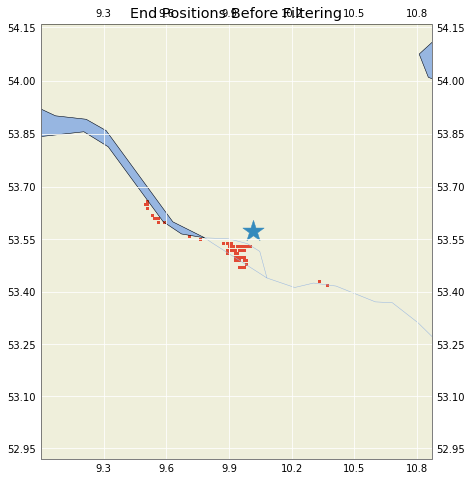

In [16]:
# Plot end positions before any filtering to map
aismap.plot_to_map(size = (8, 8), longitude = ais_dropped['EndLongitude'], latitude = ais_dropped['EndLatitude'])
plt.title("End Positions Before Filtering")

In [17]:
# Get rid of trips that leave our zone (2.45 - 10.66 / 51.49 - 55.06)

outside_long_mask = (ais_dropped['Longitude'] < 2.45) | (ais_dropped['Longitude'] > 10.66)
outside_lat_mask = (ais_dropped['Latitude'] < 51.49) | (ais_dropped['Latitude'] > 55.06)

outside_rec_mask = outside_long_mask | outside_lat_mask

outside_trip_ids = ais_dropped['TripID'][outside_rec_mask].unique()
outside_trip_mask = ~ais_dropped['TripID'].isin(outside_trip_ids)
ais_zoned = ais_dropped[outside_trip_mask]

Text(0.5,1,u'All Positions After Filtering to Our Zone')

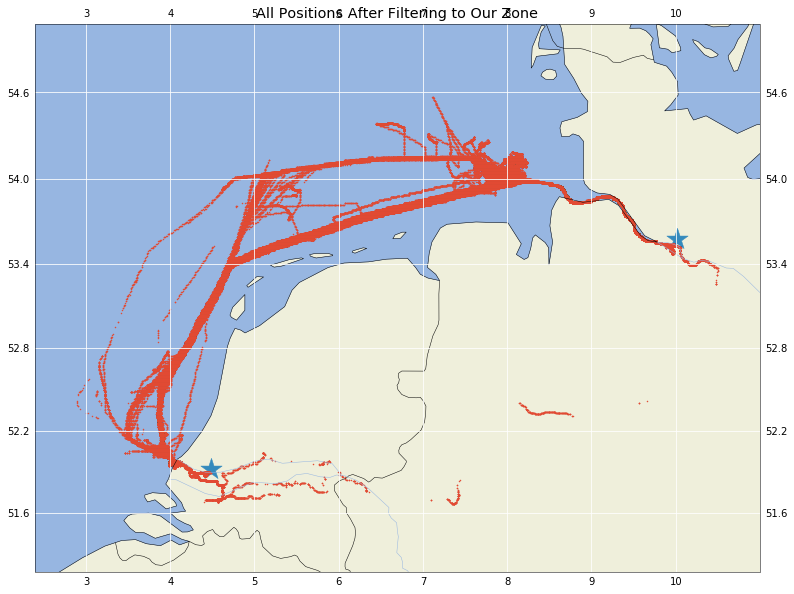

In [18]:
aismap.plot_to_map(size = (13, 13), longitude = ais_zoned['Longitude'], latitude = ais_zoned['Latitude'])
plt.title("All Positions After Filtering to Our Zone")

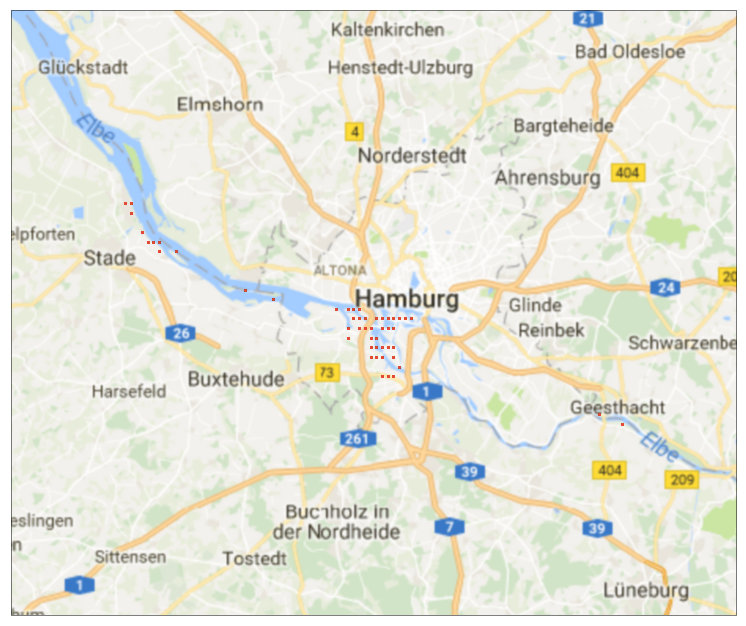

In [19]:
minlat = ais_zoned['EndLatitude'].min() - 0.2
maxlat = ais_zoned['EndLatitude'].max() + 0.2
minlong = ais_zoned['EndLongitude'].min() - 0.2
maxlong = ais_zoned['EndLongitude'].max() + 0.2

aismap.plot_google_map((minlong, maxlong, minlat, maxlat))
plt.scatter(x = ais_zoned['EndLongitude'], y = ais_zoned['EndLatitude'] , transform = ccrs.PlateCarree(), s = 1)

In [20]:
# Get times finish line is crossed, by trips that do cross it
finish_line_ts = ais_zoned[ais_zoned['Longitude'] > 9.81].groupby('TripID')['time'].min()

# Only keep trips that do cross the finish line
ais_ham_zoned = ais_zoned[ais_zoned['TripID'].isin(finish_line_ts.index)]

#Set EndTime to the time the ship first appears behind the finish line
for tripid in finish_line_ts.index :
    ais_ham_zoned.loc[ais_ham_zoned['TripID'] == tripid, 'EndTime'] = finish_line_ts.loc[tripid]

# Throw out all records after the finish line was crossed
ais_ham_zoned = ais_ham_zoned[ais_ham_zoned['time'] <= ais_ham_zoned['EndTime']]

/Users/jankaiser/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


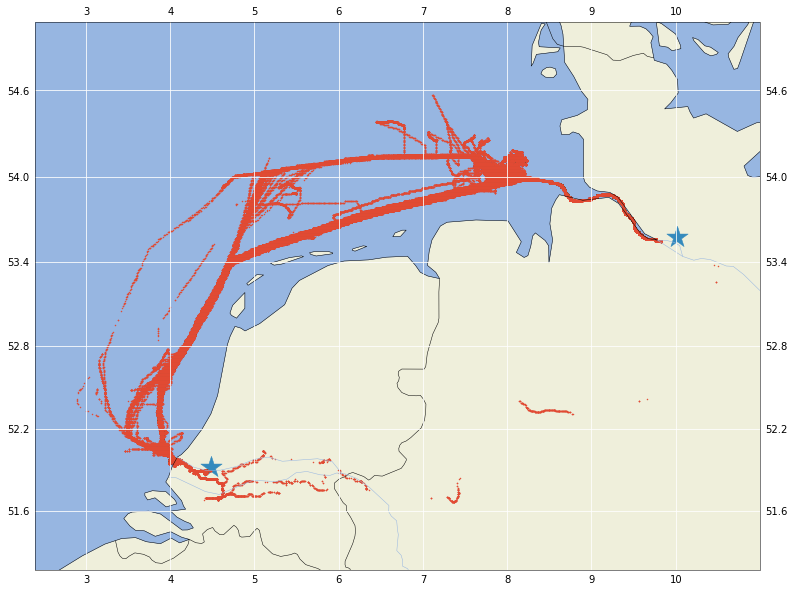

In [21]:
aismap.plot_to_map(size = (13, 13), longitude = ais_ham_zoned['Longitude'], latitude = ais_ham_zoned['Latitude'])

In [22]:
ais_tts = ais_ham_zoned
ais_tts.is_copy = False   # Hack to silence SettingWithCopyWarning

# Add time for the entire trip to the data
ais_tts['TravelTime'] = ais_tts['EndTime'] - ais_tts['StartTime']
ais_tts['TravelTimeMins'] = ais_tts['TravelTime'].transform(lambda x : x.total_seconds() / 60)

# Add time remaining until arrival at destination
ais_tts['remainingTT'] = ais_tts['EndTime'] - ais_tts['time']
ais_tts['remainingMins'] = ais_tts['remainingTT'].transform(lambda x : x.total_seconds() / 60)

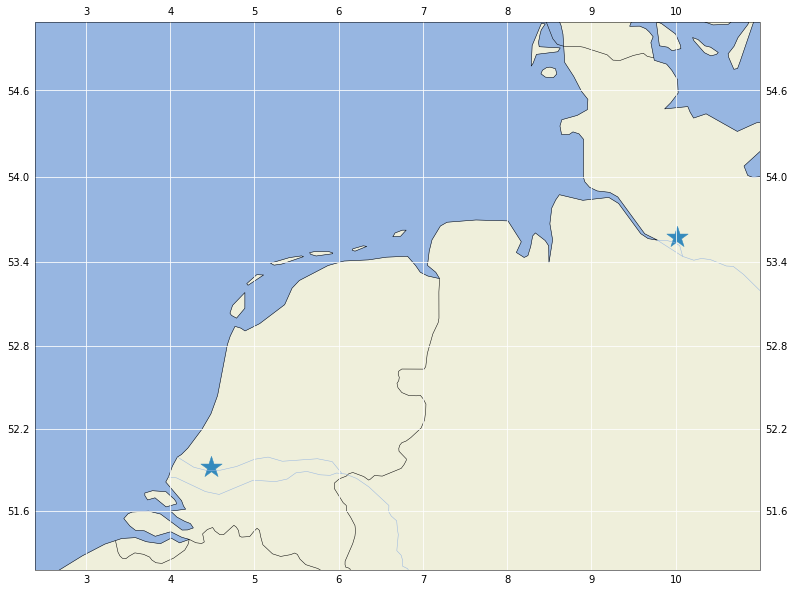

In [23]:
aismap.plot_trips(ais_tts, 'TravelTime')

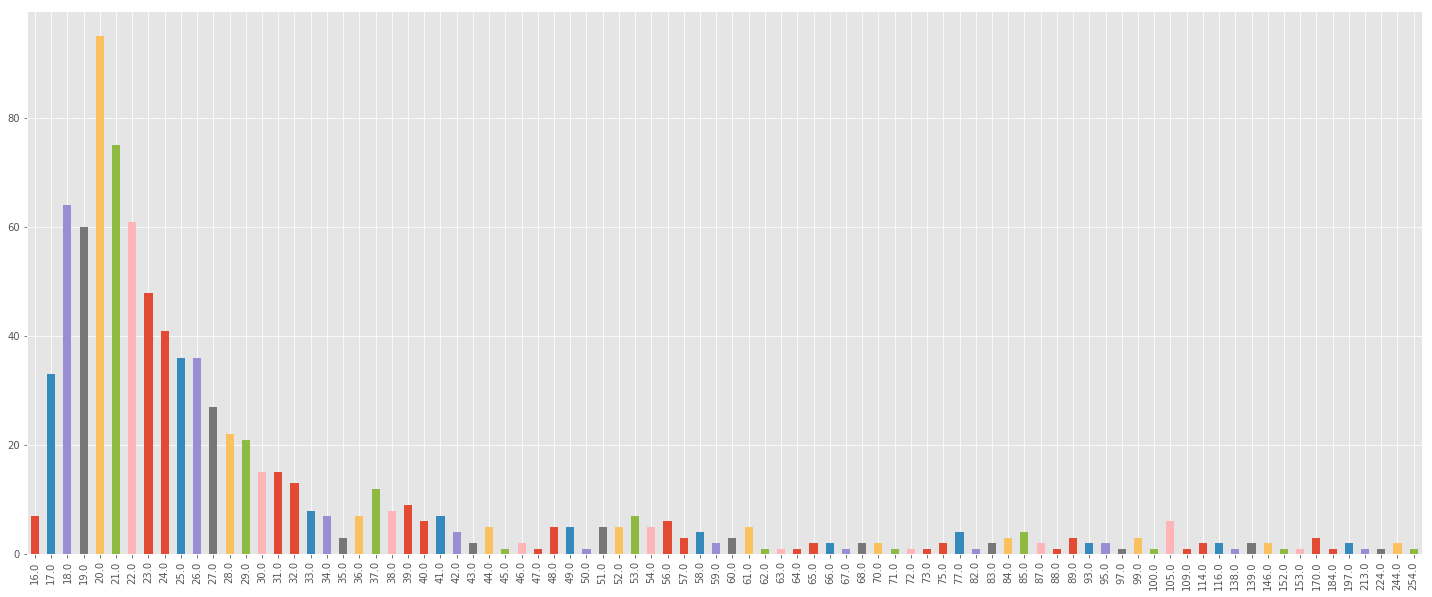

In [24]:
travel_times = ais_tts.groupby('TripID')['TravelTime'].max()
travel_times = travel_times.transform(lambda x : x.total_seconds() // 3600)
travel_times.value_counts().sort_index().plot.bar(figsize = (25, 10))

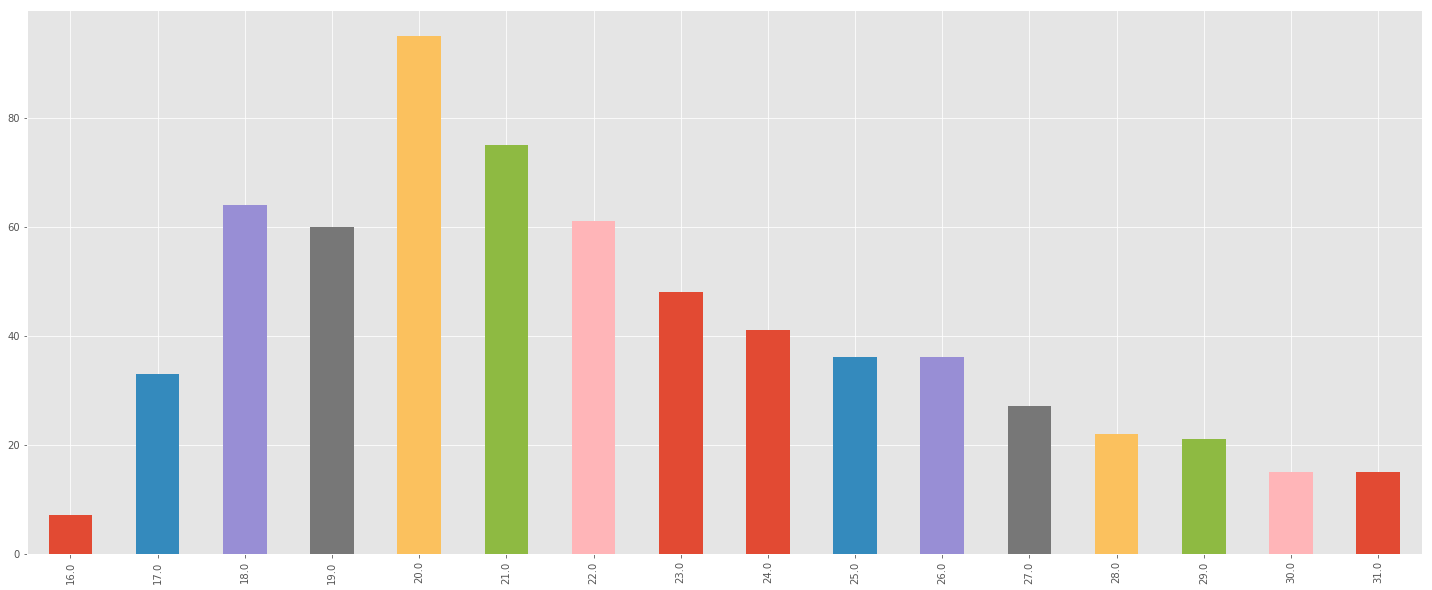

In [25]:
travel_times[travel_times < travel_times.quantile(.75)].value_counts().sort_index().plot.bar(figsize = (25, 10))

In [26]:
# Only keep majority of shorter trips
ais_shortmaj = ais_tts[ais_tts['TravelTime'] < ais_tts['TravelTime'].quantile(.75)]

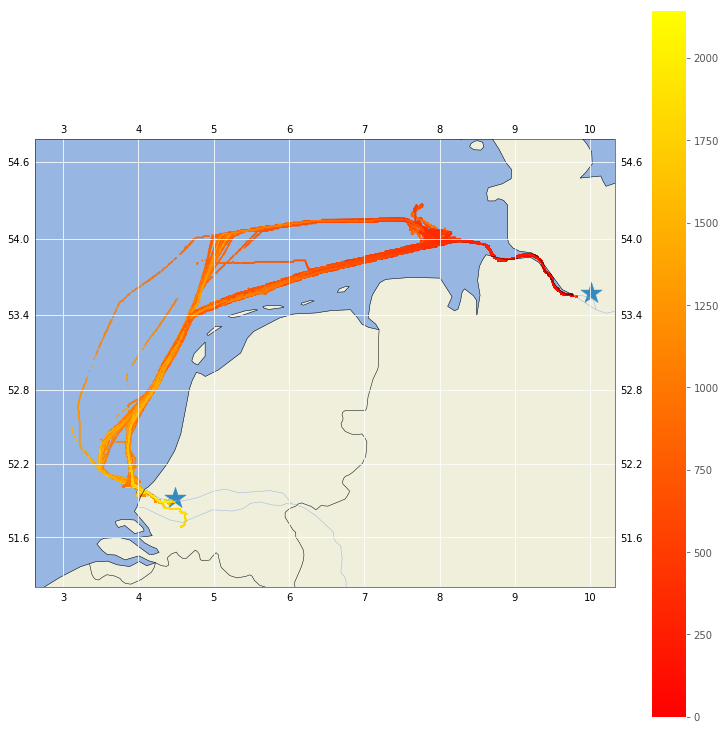

In [27]:
aismap.col_plot_to_map(size = (13, 13), longitude = ais_shortmaj['Longitude'], latitude = ais_shortmaj['Latitude'], col= ais_shortmaj['remainingMins'])

In [28]:
# Get and plot the longest trip in the data set
longest_trip = ais_shortmaj[ais_shortmaj['TravelTime'] == ais_shortmaj['TravelTime'].max()]
longest_trip.head()

,TripID,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,time,Length,Breadth,...,Longitude,SOG,COG,TH,Destination,Callsign,TravelTime,TravelTimeMins,remainingTT,remainingMins
382931,564667,51.94,4.05,2016-05-28 06:46:00,53.52,9.92,2016-05-29 18:31:00,2016-05-28 08:38:00,184.0,26.0,...,3.90,14.0,349.0,347.0,DEHAM,5BSL2,1 days 11:45:00,2145.0,1 days 09:53:00,2033.0
383053,564667,51.94,4.05,2016-05-28 06:46:00,53.52,9.92,2016-05-29 18:31:00,2016-05-28 07:10:00,184.0,26.0,...,4.08,6.0,40.0,26.0,DEHAM,5BSL2,1 days 11:45:00,2145.0,1 days 11:21:00,2121.0
383129,564667,51.94,4.05,2016-05-28 06:46:00,53.52,9.92,2016-05-29 18:31:00,2016-05-28 06:46:00,184.0,26.0,...,4.05,1.6,175.0,292.0,DEHAM,5BSL2,1 days 11:45:00,2145.0,1 days 11:45:00,2145.0
383130,564667,51.94,4.05,2016-05-28 06:46:00,53.52,9.92,2016-05-29 18:31:00,2016-05-28 06:49:00,184.0,26.0,...,4.05,1.3,267.0,12.0,DEHAM,5BSL2,1 days 11:45:00,2145.0,1 days 11:42:00,2142.0
383131,564667,51.94,4.05,2016-05-28 06:46:00,53.52,9.92,2016-05-29 18:31:00,2016-05-28 06:52:00,184.0,26.0,...,4.05,1.0,89.0,75.0,DEHAM,5BSL2,1 days 11:45:00,2145.0,1 days 11:39:00,2139.0


Text(0.5,1,u'Longest Trip in the Data Set')

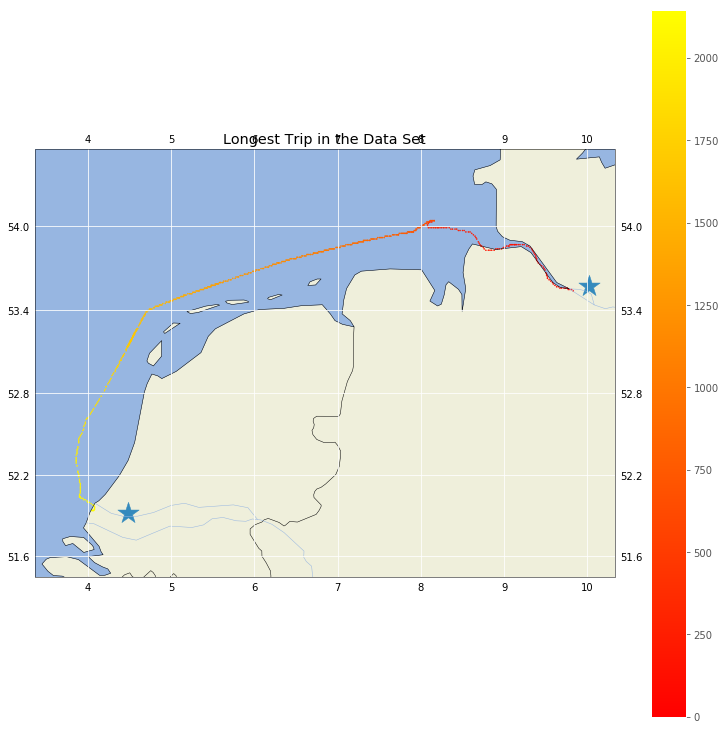

In [29]:
aismap.col_plot_to_map(size = (13, 13), longitude = longest_trip['Longitude'], latitude = longest_trip['Latitude'], col = longest_trip['remainingMins'])
plt.title("Longest Trip in the Data Set")

In [30]:
ais_dists = ais_shortmaj
ais_dists.is_copy = False

ais_dists['dist_to_end'] = ais_dists.apply(lambda x : aismap.route_dist_to_ham(x['Latitude'], x['Longitude']), axis = 1)
ais_dists.head()

,TripID,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,time,Length,Breadth,...,SOG,COG,TH,Destination,Callsign,TravelTime,TravelTimeMins,remainingTT,remainingMins,dist_to_end
0,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:04:00,269.0,32.0,...,14.7,81.0,80.0,HAMBURG,5BND2,1 days 00:37:00,1477.0,07:05:00,425.0,146.827424
1,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:05:00,269.0,32.0,...,14.7,80.0,80.0,HAMBURG,5BND2,1 days 00:37:00,1477.0,07:04:00,424.0,146.185516
2,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:06:00,269.0,32.0,...,14.7,81.0,80.0,HAMBURG,5BND2,1 days 00:37:00,1477.0,07:03:00,423.0,146.185516
3,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:07:00,269.0,32.0,...,14.7,80.0,80.0,HAMBURG,5BND2,1 days 00:37:00,1477.0,07:02:00,422.0,145.544334
4,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:08:00,269.0,32.0,...,14.7,81.0,80.0,HAMBURG,5BND2,1 days 00:37:00,1477.0,07:01:00,421.0,144.903944


In [31]:
ais_tfeats = ais_dists
ais_tfeats.is_copy = False

ais_tfeats['hour_of_day'] = ais_tfeats['time'].dt.hour
ais_tfeats['weekday'] = ais_tfeats['time'].dt.dayofweek
ais_tfeats['day_of_month'] = ais_tfeats['time'].dt.day
ais_tfeats['month'] = ais_tfeats['time'].dt.month

In [32]:
ais_tfeats['weekday'].describe()

count    831853.000000
mean          2.947164
std           1.955274
min           0.000000
25%           1.000000
50%           3.000000
75%           5.000000
max           6.000000
Name: weekday, dtype: float64

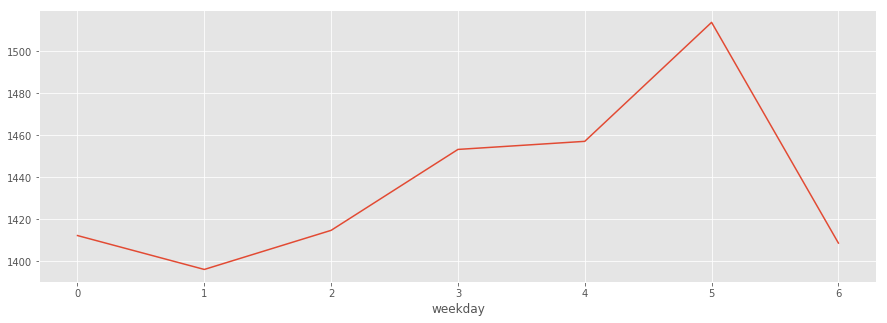

In [33]:
ais_tfeats.groupby('weekday')['TravelTimeMins'].mean().plot(figsize = (15, 5))

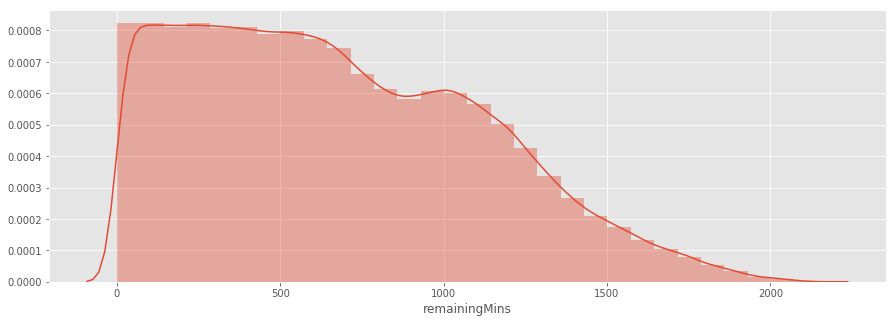

In [34]:
plt.figure(figsize = (15, 5))
sns.distplot(ais_tfeats['remainingMins'], bins = 30)

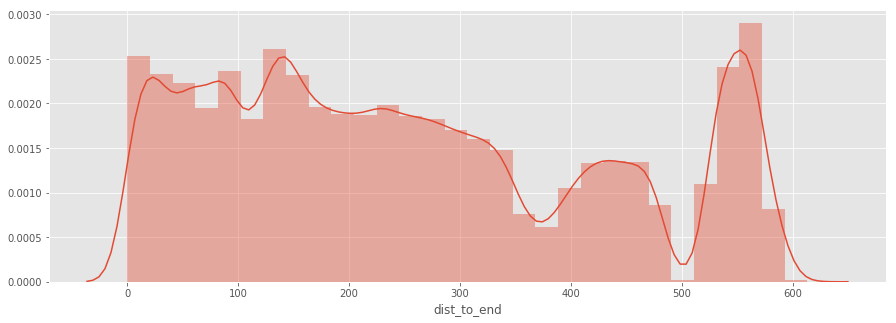

In [35]:
plt.figure(figsize = (15, 5))
sns.distplot(ais_tfeats['dist_to_end'], bins = 30)

In [36]:
ais_tfeats['Longitude'].describe()

count    831853.000000
mean          6.554307
std           1.993443
min           3.120000
25%           4.400000
50%           6.580000
75%           8.340000
max           9.830000
Name: Longitude, dtype: float64

In [89]:
# Assign sector IDs according to Longitude ranges (5 sectors for ROT-HAM route)
ais_sectors = ais_tfeats.copy()
ais_sectors.loc[(ais_sectors['Longitude'] <= 4.8) & (ais_sectors['Latitude'] <= 52.8), 'sector_id'] = '0'
ais_sectors.loc[(ais_sectors['Longitude'] <= 4.8) & (ais_sectors['Latitude'] > 52.8), 'sector_id'] = '2'
ais_sectors.loc[(ais_sectors['Longitude'] > 4.8) & (ais_sectors['Longitude'] <= 6.0), 'sector_id'] = '3'
ais_sectors.loc[(ais_sectors['Longitude'] > 6.0) & (ais_sectors['Longitude'] <= 7.2), 'sector_id'] = '4'
ais_sectors.loc[(ais_sectors['Longitude'] > 7.2) & (ais_sectors['Longitude'] <= 8.6), 'sector_id'] = '5'
ais_sectors.loc[ais_sectors['Longitude'] > 8.6, 'sector_id'] = '6'

In [90]:
ais_sectors.head()

,TripID,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,time,Length,Breadth,...,TravelTime,TravelTimeMins,remainingTT,remainingMins,dist_to_end,hour_of_day,weekday,day_of_month,month,sector_id
0,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:04:00,269.0,32.0,...,1 days 00:37:00,1477.0,07:05:00,425.0,146.827424,22,3,21,1,5
1,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:05:00,269.0,32.0,...,1 days 00:37:00,1477.0,07:04:00,424.0,146.185516,22,3,21,1,5
2,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:06:00,269.0,32.0,...,1 days 00:37:00,1477.0,07:03:00,423.0,146.185516,22,3,21,1,5
3,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:07:00,269.0,32.0,...,1 days 00:37:00,1477.0,07:02:00,422.0,145.544334,22,3,21,1,5
4,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:08:00,269.0,32.0,...,1 days 00:37:00,1477.0,07:01:00,421.0,144.903944,22,3,21,1,5


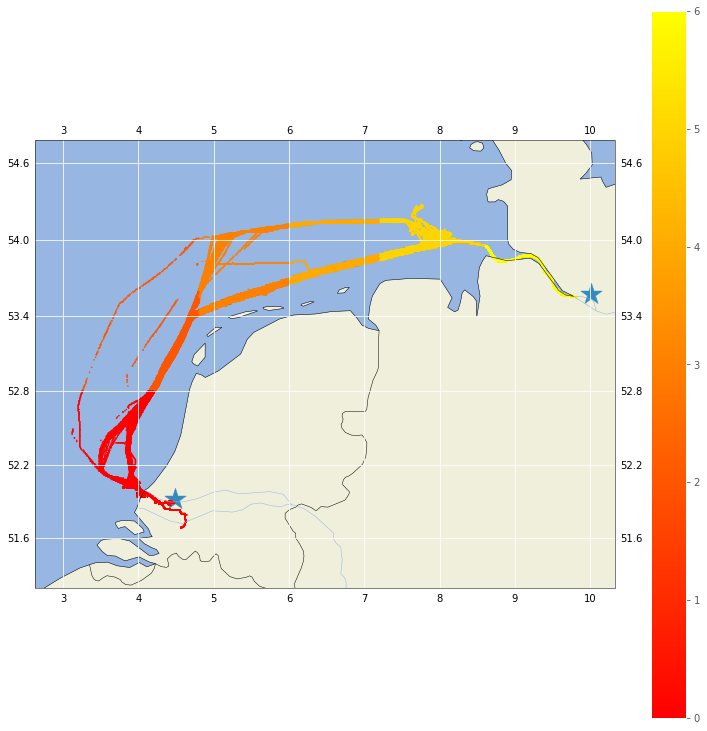

In [91]:
aismap.col_plot_to_map(size = (13, 13), longitude = ais_sectors['Longitude'], latitude = ais_sectors['Latitude'], col = ais_sectors['sector_id'])

In [92]:
ais_sectors['sector_id'].value_counts()

6    182478
0    177287
5    166288
4    128367
3    111539
2     65894
Name: sector_id, dtype: int64

In [94]:
ais_sectors.groupby(['TripID', 'sector_id'])['time'].max()

TripID   sector_id
1000226  0           2016-06-15 19:58:00
         2           2016-06-15 23:24:00
         3           2016-06-16 03:01:00
         4           2016-06-16 06:19:00
         5           2016-06-16 10:39:00
         6           2016-06-16 15:51:00
1005318  0           2016-04-27 20:41:00
         2           2016-04-27 22:00:00
         3           2016-04-28 01:05:00
         4           2016-04-28 03:17:00
         5           2016-04-28 06:29:00
         6           2016-04-28 10:56:00
1005340  0           2016-07-06 20:43:00
         2           2016-07-06 23:11:00
         3           2016-07-07 01:44:00
         4           2016-07-07 04:27:00
         5           2016-07-07 08:18:00
         6           2016-07-07 12:58:00
1016762  0           2016-02-11 03:54:00
         2           2016-02-11 07:05:00
         3           2016-02-11 10:00:00
         4           2016-02-11 12:53:00
         5           2016-02-12 02:32:00
         6           2016-02-12 06:34:

In [ ]:
ais_tfeats.columns

In [ ]:
learners = ['TripID', 'time', 'Length', 'Breadth', 'Draught', 'Latitude', 'Longitude',
            'SOG', 'COG', 'TH', 'remainingMins', 'dist_to_end', 'hour_of_day',
            'weekday', 'day_of_month', 'month']

In [ ]:
# Export without downsampling
ais_learners = ais_tfeats[learners]
ais_learners = ais_learners.dropna()
ais_learners.to_pickle('ROT-HAM_learners_01min.pkl')
ais_learners.head()

In [ ]:
# Export downsampled to 5 minutes
ais_downsampled = ais_tfeats.copy()
ais_downsampled.index = ais_downsampled['time']
ais_downsampled = ais_downsampled.groupby('TripID').apply(lambda x : x.resample('5T').mean()).reset_index()

ais_learners = ais_downsampled[learners]
ais_learners = ais_learners.dropna()
ais_learners.to_pickle('ROT-HAM_learners_05min.pkl')
ais_learners.head()

In [ ]:
# Export downsampled to 10 minutes
ais_downsampled = ais_tfeats.copy()
ais_downsampled.index = ais_downsampled['time']
ais_downsampled = ais_downsampled.groupby('TripID').apply(lambda x : x.resample('10T').mean()).reset_index()

ais_learners = ais_downsampled[learners]
ais_learners = ais_learners.dropna()
ais_learners.to_pickle('ROT-HAM_learners_10min.pkl')
ais_learners.head()

In [ ]:
# Export downsampled to 15 minutes
ais_downsampled = ais_tfeats.copy()
ais_downsampled.index = ais_downsampled['time']
ais_downsampled = ais_downsampled.groupby('TripID').apply(lambda x : x.resample('15T').mean()).reset_index()

ais_learners = ais_downsampled[learners]
ais_learners = ais_learners.dropna()
ais_learners.to_pickle('ROT-HAM_learners_15min.pkl')
ais_learners.head()

In [ ]:
# Export downsampled to 30 minutes
ais_downsampled = ais_tfeats.copy()
ais_downsampled.index = ais_downsampled['time']
ais_downsampled = ais_downsampled.groupby('TripID').apply(lambda x : x.resample('30T').mean()).reset_index()

ais_learners = ais_downsampled[learners]
ais_learners = ais_learners.dropna()
ais_learners.to_pickle('ROT-HAM_learners_30min.pkl')
ais_learners.head()

In [ ]:
# Export downsampled to 60 minutes
ais_downsampled = ais_tfeats.copy()
ais_downsampled.index = ais_downsampled['time']
ais_downsampled = ais_downsampled.groupby('TripID').apply(lambda x : x.resample('60T').mean()).reset_index()

ais_learners = ais_downsampled[learners]
ais_learners = ais_learners.dropna()
ais_learners.to_pickle('ROT-HAM_learners_60min.pkl')
ais_learners.head()